# Jit compilation with Numba

This is a rendered copy of [advanced_numba.ipynb](https://github.com/scikit-hep/coffea/blob/master/binder/advanced_numba.ipynb). You can optionally run it interactively on [binder at this link](https://mybinder.org/v2/gh/coffeateam/coffea/master?filepath=binder%2Fadvanced_numba.ipynb)

The purpose of this notebook is to teach you how to express operations that are hard to express in an array-oriented way in an imperative way and then jit compile them using numba and execute them as part of your coffea workflow.

It heavily builds on top of [processing.ipynb](https://github.com/scikit-hep/coffea/blob/master/binder/processing.ipynb), so please read that one first.

In [1]:
import hist
import hist.dask
import dask
import awkward as ak
import dask_awkward as dak
import matplotlib.pyplot as plt

from coffea import processor
from coffea.nanoevents import BaseSchema
from coffea.nanoevents.methods import candidate
from coffea.dataset_tools import (
    apply_to_fileset,
    preprocess,
)

In [2]:
from dask.distributed import Client

# here we connect to the cluster of our analysis facility.
# if you are on coffea-casa for example, that should be something like
# client = Client("tls://localhost:8786")
# locally we can make our own cluster though
from dask.distributed import LocalCluster

cluster = LocalCluster(threads_per_worker=1)
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 14
Total threads: 14,Total memory: 36.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57032,Workers: 14
Dashboard: http://127.0.0.1:8787/status,Total threads: 14
Started: Just now,Total memory: 36.00 GiB
Comm: tcp://127.0.0.1:57063,Total threads: 1
Dashboard: http://127.0.0.1:57064/status,Memory: 2.57 GiB
Nanny: tcp://127.0.0.1:57035,


BokehUserWarning: reference already known 'p1011'

BokehUserWarning: reference already known 'p1051'

BokehUserWarning: reference already known 'p1289'

BokehUserWarning: reference already known 'p1295'

BokehUserWarning: reference already known 'p1361'

In [3]:
fileset = {
    "DoubleMuon": {
        "files": {
            "/Users/iason/work/pyhep_dev/uscms-idap-training/coffea/Run2012B_DoubleMuParked.root": "Events",
            # "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root": "Events",
            "/Users/iason/work/pyhep_dev/uscms-idap-training/coffea/Run2012C_DoubleMuParked.root": "Events",
            # "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012C_DoubleMuParked.root": "Events",
        },
        "metadata": {
            "is_mc": False,
        },
    },
    "ZZ to 4mu": {
        "files": {
            "/Users/iason/work/pyhep_dev/uscms-idap-training/coffea/ZZTo4mu.root": "Events",
            # "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/ZZTo4mu.root": "Events",
        },
        "metadata": {
            "is_mc": True,
        },
    },
}

dataset_runnable, dataset_updated = preprocess(
    fileset,
    align_clusters=False,
    step_size=100_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

## Getting fancy
Let's flesh out the processor from the `procesing.ipynb` notebook into a 4-muon analysis, searching for diboson events:

In [4]:
import numba


@numba.njit
def find_4lep_kernel(events_leptons, builder):
    """Search for valid 4-lepton combinations from an array of events * leptons {charge, ...}

    A valid candidate has two pairs of leptons that each have balanced charge
    Outputs an array of events * candidates {indices 0..3} corresponding to all valid
    permutations of all valid combinations of unique leptons in each event
    (omitting permutations of the pairs)
    """
    for leptons in events_leptons:
        builder.begin_list()
        nlep = len(leptons)
        for i0 in range(nlep):
            for i1 in range(i0 + 1, nlep):
                if leptons[i0].charge + leptons[i1].charge != 0:
                    continue
                for i2 in range(nlep):
                    for i3 in range(i2 + 1, nlep):
                        if len({i0, i1, i2, i3}) < 4:
                            continue
                        if leptons[i2].charge + leptons[i3].charge != 0:
                            continue
                        builder.begin_tuple(4)
                        builder.index(0).integer(i0)
                        builder.index(1).integer(i1)
                        builder.index(2).integer(i2)
                        builder.index(3).integer(i3)
                        builder.end_tuple()
        builder.end_list()

    return builder


def find_4lep(events_leptons):
    if ak.backend(events_leptons) == "typetracer":
        # here we fake the output of find_4lep_kernel since
        # operating on length-zero data returns the wrong layout!
        ak.typetracer.touch_data(events_leptons.charge)  # force touching of the necessary data
        return ak.Array(ak.Array([[(0, 0, 0, 0)]]).layout.to_typetracer(forget_length=True))
    return find_4lep_kernel(events_leptons, ak.ArrayBuilder()).snapshot()


class FancyDimuonProcessor(processor.ProcessorABC):
    def __init__(self, mode="virtual"):
        assert mode in ["eager", "virtual", "dask"]
        self._mode = mode

    def process(self, events):
        dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        mass_axis = hist.axis.Regular(300, 0, 300, name="mass", label=r"$m_{\mu\mu}$ [GeV]")
        pt_axis = hist.axis.Regular(300, 0, 300, name="pt", label=r"$p_{T,\mu}$ [GeV]")

        if self._mode == "dask":
            hist_class = hist.dask.Hist
        else:
            hist_class = hist.Hist

        h_nMuons = hist_class(
            dataset_axis,
            hist.axis.IntCategory(range(6), name="nMuons", label="Number of good muons"),
            storage="weight",
            label="Counts",
        )
        h_m4mu = hist_class(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_mZ1 = hist_class(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_mZ2 = hist_class(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_ptZ1mu1 = hist_class(dataset_axis, pt_axis, storage="weight", label="Counts")
        h_ptZ1mu2 = hist_class(dataset_axis, pt_axis, storage="weight", label="Counts")

        cutflow = dict()

        dataset = events.metadata["dataset"]
        muons = ak.zip(
            {
                "pt": events.Muon_pt,
                "eta": events.Muon_eta,
                "phi": events.Muon_phi,
                "mass": events.Muon_mass,
                "charge": events.Muon_charge,
                "isolation": events.Muon_pfRelIso03_all,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        # make sure they are sorted by transverse momentum
        muons = muons[ak.argsort(muons.pt, axis=1)]

        cutflow["all events"] = ak.num(muons, axis=0)

        # impose some quality and minimum pt cuts on the muons
        muons = muons[(muons.pt > 5) & (muons.isolation < 0.2)]
        cutflow["at least 4 good muons"] = ak.sum(ak.num(muons) >= 4)
        h_nMuons.fill(dataset=dataset, nMuons=ak.num(muons))

        # reduce first axis: skip events without enough muons
        muons = muons[ak.num(muons) >= 4]

        # find all candidates with helper function
        if self._mode == "dask":
            fourmuon = dak.map_partitions(find_4lep, muons)
        else:
            fourmuon = find_4lep_kernel(ak.materialize(muons), ak.ArrayBuilder()).snapshot()
        fourmuon = [muons[fourmuon[idx]] for idx in "0123"]

        fourmuon = ak.zip(
            {
                "z1": ak.zip(
                    {
                        "lep1": fourmuon[0],
                        "lep2": fourmuon[1],
                        "p4": fourmuon[0] + fourmuon[1],
                    }
                ),
                "z2": ak.zip(
                    {
                        "lep1": fourmuon[2],
                        "lep2": fourmuon[3],
                        "p4": fourmuon[2] + fourmuon[3],
                    }
                ),
            }
        )

        cutflow["at least one candidate"] = ak.sum(ak.num(fourmuon) > 0)

        # require minimum dimuon mass
        fourmuon = fourmuon[(fourmuon.z1.p4.mass > 60.0) & (fourmuon.z2.p4.mass > 20.0)]
        cutflow["minimum dimuon mass"] = ak.sum(ak.num(fourmuon) > 0)

        # choose permutation with z1 mass closest to nominal Z boson mass
        bestz1 = ak.singletons(ak.argmin(abs(fourmuon.z1.p4.mass - 91.1876), axis=1))
        fourmuon = ak.flatten(fourmuon[bestz1])

        h_m4mu.fill(
            dataset=dataset,
            mass=(fourmuon.z1.p4 + fourmuon.z2.p4).mass,
        )
        h_mZ1.fill(
            dataset=dataset,
            mass=fourmuon.z1.p4.mass,
        )
        h_mZ2.fill(
            dataset=dataset,
            mass=fourmuon.z2.p4.mass,
        )
        h_ptZ1mu1.fill(
            dataset=dataset,
            pt=fourmuon.z1.lep1.pt,
        )
        h_ptZ1mu2.fill(
            dataset=dataset,
            pt=fourmuon.z1.lep2.pt,
        )
        return {
            "nMuons": h_nMuons,
            "mass": h_m4mu,
            "mass_z1": h_mZ1,
            "mass_z2": h_mZ2,
            "pt_z1_mu1": h_ptZ1mu1,
            "pt_z1_mu2": h_ptZ1mu2,
            "cutflow": {dataset: cutflow},
        }

    def postprocess(self, accumulator):
        pass

In [5]:
import time

tstart = time.time()

run = processor.Runner(
    executor=processor.DaskExecutor(client=client, compression=None),
    schema=BaseSchema,
    chunksize=100_000,
)

out = run(
    fileset,
    processor_instance=FancyDimuonProcessor("virtual"),
)

elapsed = time.time() - tstart
elapsed

Processing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701/701 [ 0:00:10 < 0:00:00 | 65.4 chunk/s ]

11.421343088150024

In [6]:
nevt = out["cutflow"]["ZZ to 4mu"]["all events"] + out["cutflow"]["DoubleMuon"]["all events"]
print("Events/s:", nevt / elapsed)

Events/s: 5801716.61849036


What follows is just us looking at the output, you can execute it if you wish

In [7]:
# scale ZZ simulation to expected yield
lumi = 11.6  # 1/fb
zzxs = 7200 * 0.0336**2  # approximate 8 TeV ZZ(4mu)
nzz = out["cutflow"]["ZZ to 4mu"]["all events"]

scaled = {}
for name, h in out.items():
    if isinstance(h, hist.Hist):
        scaled[name] = h.copy()
        scaled[name].view()[1, :] *= lumi * zzxs / nzz

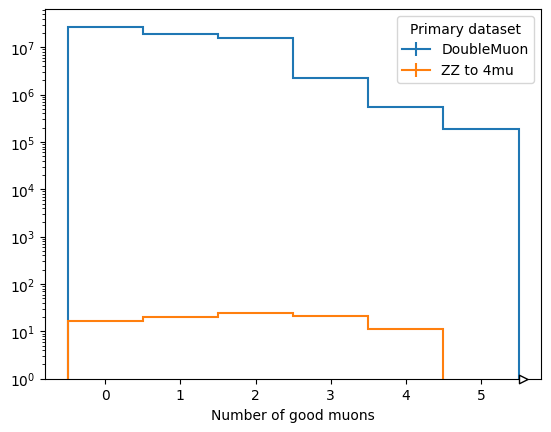

In [8]:
fig, ax = plt.subplots()

scaled["nMuons"].plot1d(ax=ax, overlay="dataset")
ax.set_yscale("log")
ax.set_ylim(1, None)
plt.show()

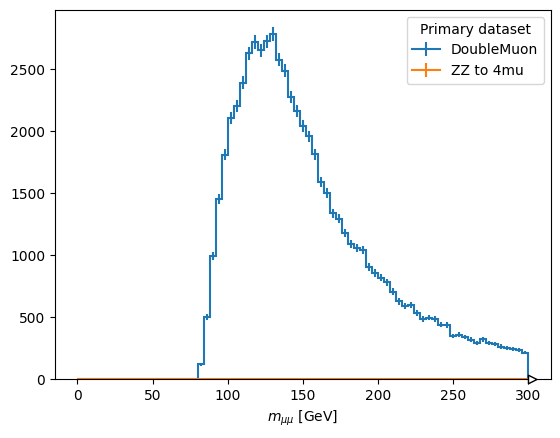

In [9]:
fig, ax = plt.subplots()

scaled["mass"][:, :: hist.rebin(4)].plot1d(ax=ax, overlay="dataset")
plt.show()

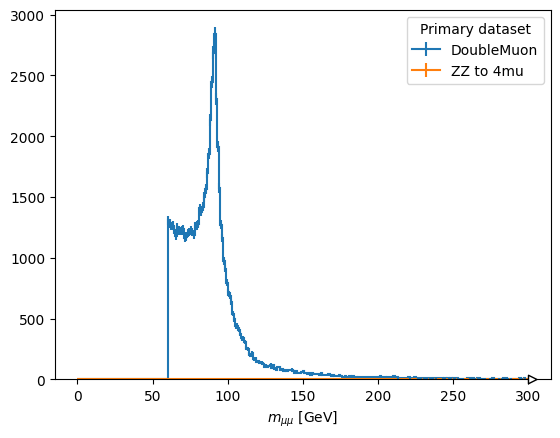

In [10]:
fig, ax = plt.subplots()

scaled["mass_z1"].plot1d(ax=ax, overlay="dataset")
plt.show()

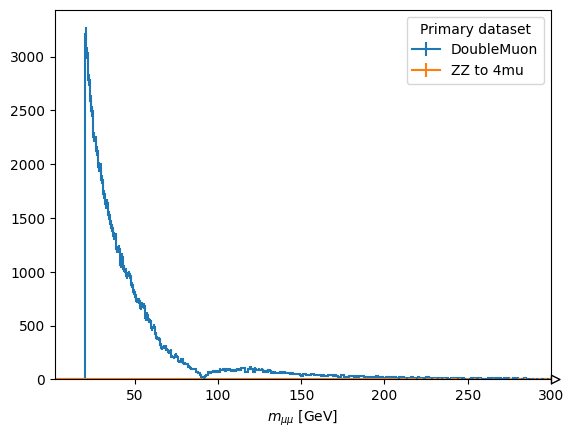

In [11]:
fig, ax = plt.subplots()

scaled["mass_z2"].plot1d(ax=ax, overlay="dataset")
ax.set_xlim(2, 300)
plt.show()

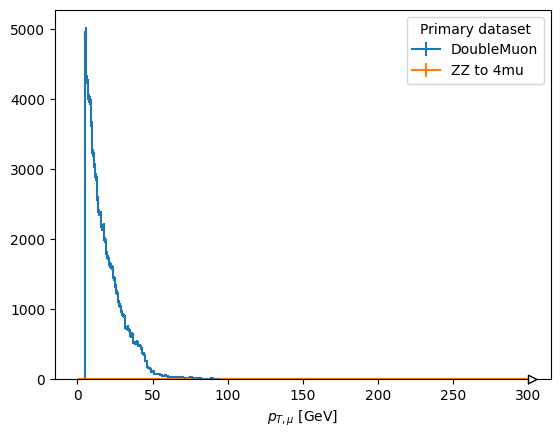

In [12]:
fig, ax = plt.subplots()

scaled["pt_z1_mu1"].plot1d(ax=ax, overlay="dataset")
plt.show()

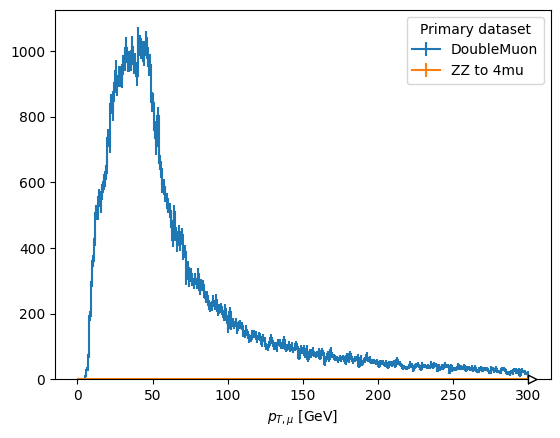

In [13]:
fig, ax = plt.subplots()

scaled["pt_z1_mu2"].plot1d(ax=ax, overlay="dataset")
plt.show()

In [14]:
import time

tstart = time.time()

to_compute = apply_to_fileset(
    FancyDimuonProcessor("dask"),
    dataset_runnable,
    schemaclass=BaseSchema,
)
(out,) = dask.compute(to_compute)

elapsed = time.time() - tstart
elapsed

29.73838996887207

In [15]:
nevt = out["ZZ to 4mu"]["cutflow"]["ZZ to 4mu"]["all events"] + out["DoubleMuon"]["cutflow"]["DoubleMuon"]["all events"]
print("Events/s:", (nevt / elapsed))

Events/s: 2228210.6082191938


What follows is just us looking at the output, you can execute it if you wish

In [16]:
# scale ZZ simulation to expected yield
lumi = 11.6  # 1/fb
zzxs = 7200 * 0.0336**2  # approximate 8 TeV ZZ(4mu)
nzz = out["ZZ to 4mu"]["cutflow"]["ZZ to 4mu"]["all events"]

scaled = {}
for (name1, h1), (nam2, h2) in zip(out["DoubleMuon"].items(), out["ZZ to 4mu"].items()):
    if isinstance(h1, hist.Hist) and isinstance(h2, hist.Hist):
        scaled[name1] = h1.copy() + h2.copy()
        scaled[name1].view()[1, :] *= lumi * zzxs / nzz

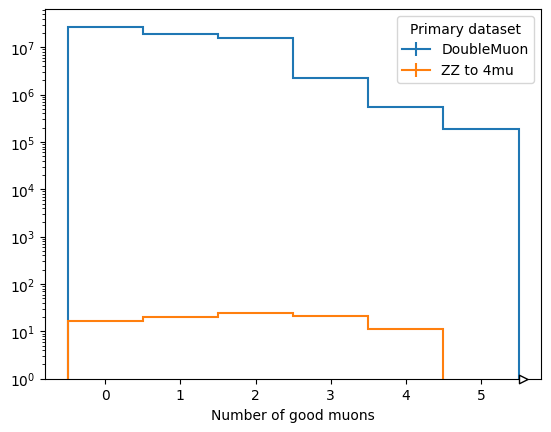

In [17]:
fig, ax = plt.subplots()

scaled["nMuons"].plot1d(ax=ax, overlay="dataset")
ax.set_yscale("log")
ax.set_ylim(1, None)
plt.show()

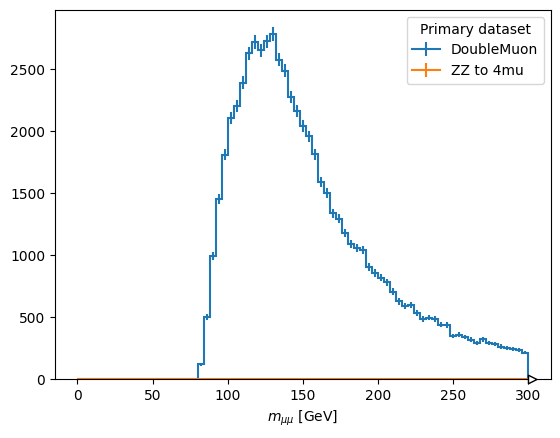

In [18]:
fig, ax = plt.subplots()

scaled["mass"][:, :: hist.rebin(4)].plot1d(ax=ax, overlay="dataset")
plt.show()

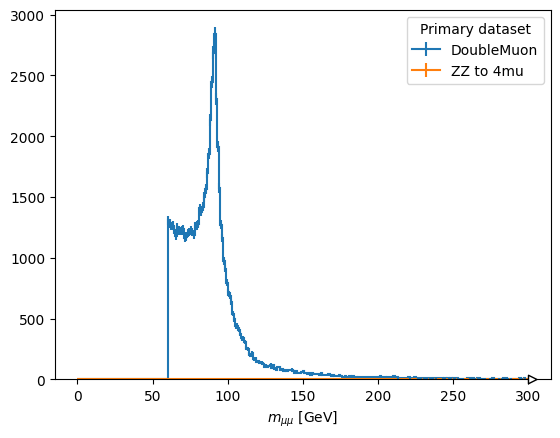

In [19]:
fig, ax = plt.subplots()

scaled["mass_z1"].plot1d(ax=ax, overlay="dataset")
plt.show()

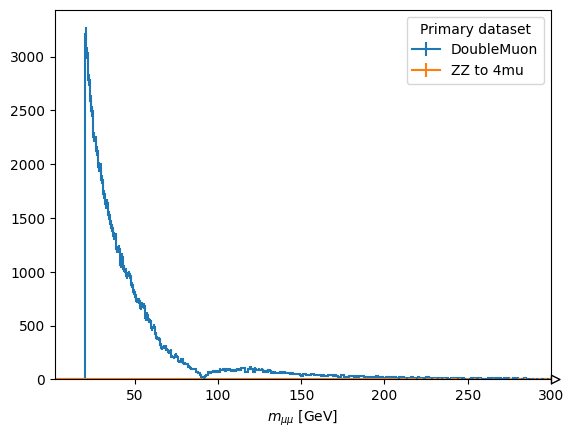

In [20]:
fig, ax = plt.subplots()

scaled["mass_z2"].plot1d(ax=ax, overlay="dataset")
ax.set_xlim(2, 300)
plt.show()

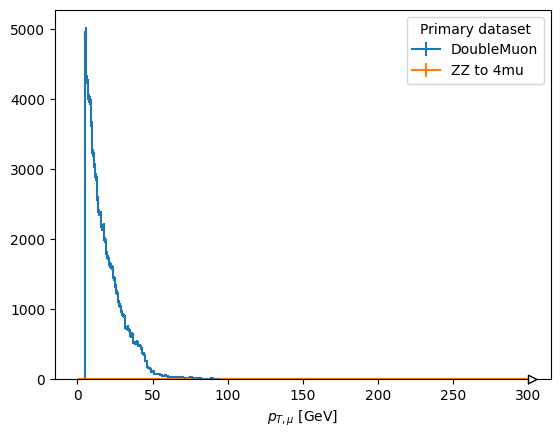

In [21]:
fig, ax = plt.subplots()

scaled["pt_z1_mu1"].plot1d(ax=ax, overlay="dataset")
plt.show()

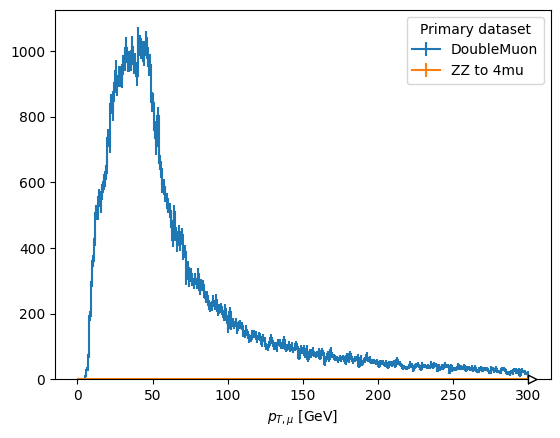

In [22]:
fig, ax = plt.subplots()

scaled["pt_z1_mu2"].plot1d(ax=ax, overlay="dataset")
plt.show()